## CLM-PPE LHC Biogeochemistry 
#### Updated May 25, 2023

- Assess parametric uncertainty in biogeochemical cycling
  - LAI latin hypercube ensemble


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import seaborn as sns
import gpflow

import warnings
warnings.filterwarnings("ignore")



from SALib.sample import fast_sampler
from SALib.analyze import fast

2023-06-09 12:49:45.880153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 12:49:46.053661: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-09 12:49:46.099227: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-09 12:49:47.167241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ;
from ppe_analysis.analysis import *
from emulation_pyfunctions import *

### Load CLM-PPE

In [3]:
# load LHC post processed data
file = '/glade/u/home/djk2120/ppe_clean/postp/lhc/ccycle.ann.LHC.nc'
ds = xr.open_dataset(file)

In [4]:
la=xr.open_dataset('sparsegrid_landarea.nc').landarea
cf=1e-9*la.sum()*24*60*60*365

In [5]:
ds['LandSink'] = cf*(ds['NEP'] - ds['COL_FIRE_CLOSS'])

In [6]:
# load parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')
num_params = len(ppe_params.columns)

### Carbon project figure

In [7]:
var = 'LandSink'
t=slice(str(1960),str(2014))
ds_var = ds[var].sel(year=t)

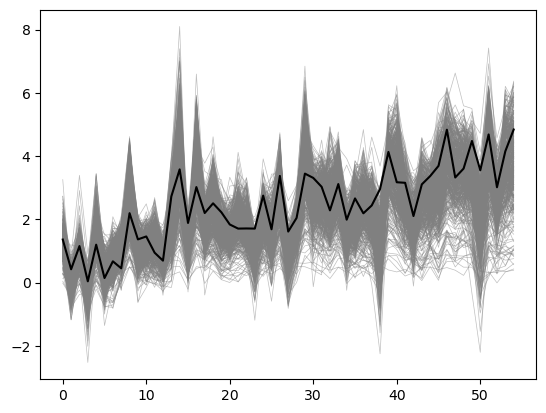

In [8]:
for i in range(501):
    var = ds_var.sel(biome='Global',ens=i)
    plt.plot(var,color='grey',linewidth=0.5,alpha=0.5)
plt.plot(ds_var.sel(biome='Global',ens=0),color='k',label='Default CLM')

### Train Biome Specific Emulators

In [9]:
def train_GPemulator(data,params,ntest,ax,kernel=None):
    Y = standardize(data)
    
    # split training and testing data
    X_test, X_train = params[:ntest], params[ntest:]
    y_test, y_train = Y[:ntest], Y[ntest:]
    
    # define emulator model and train
    if kernel is not None : 
        emulator = gp_model(np.array(X_train),np.array(y_train),kernel=kernel)
    else:
        emulator = gp_model(np.array(X_train),np.array(y_train)) # using default kernel
    
    emulator.train()
    
    plot_validation(emulator, X_test, y_test, ax)
    
    return emulator

In [10]:
# data
var = 'LandSink'
t=slice(str(2001),str(2014))
ds_in = ds[var].sel(year=t).mean(dim='year')

In [11]:
# define kernel
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))

kernel = kernel_linear + kernel_matern32 + kernel_RBF

2023-06-09 12:50:09.135339: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-09 12:50:09.135390: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc62): /proc/driver/nvidia/version does not exist
2023-06-09 12:50:09.138187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
ds_in.biome.values

array(['Global', 'Ice sheet', 'Tropical rain forest',
       'Tropical seasonal forest/savanna', 'Subtropical desert',
       'Temperate rain forest', 'Temperate seasonal forest',
       'Woodland/shrubland', 'Temperate grassland/desert',
       'Boreal forest', 'Tundra'], dtype=object)

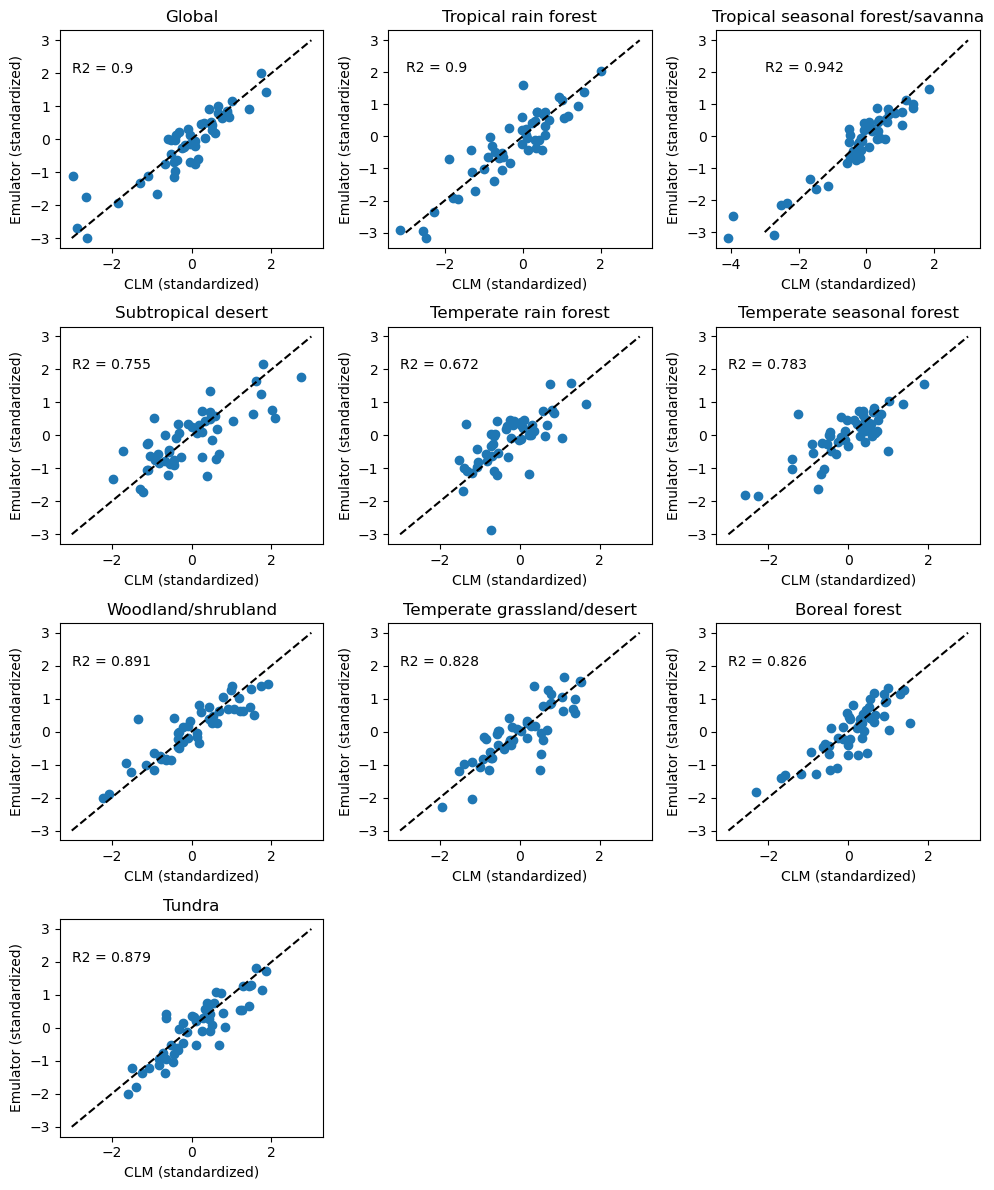

In [13]:
# train emulators and save in a dictionary 
plt.figure(figsize=[10,12])
plt.rcParams.update({'font.size': 10})

BM_emulator_dict = {}
keys = ds_in.biome.values

for i,b in enumerate([0,2,3,4,5,6,7,8,9,10]):

    y_data = ds_in.isel(biome=b)
    
    ax = plt.subplot(4,3,i+1)

    emulator = train_GPemulator(y_data[1:],ppe_params,50,ax)
    
    BM_emulator_dict[keys[b]] = emulator
    
    ax.set_title(ds_in.biome[b].values)

plt.tight_layout()
#plt.savefig('./working_dir/figs/BGC_cesm23/Biome_LandSink_emulator_validation.png',dpi = 100)

### OAAT with Emulator

In [14]:
# One-at-a-time sensitivity 
n=21
s = np.linspace(0,1,n)
unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
unif.columns = ppe_params.columns
#unif['leafcn'] = np.tile(0.8,n) # change individual parameter default setting for OAAT

In [13]:
plt.figure(figsize=[14,12])
# y-axis is 

sample = unif
for k, b in enumerate(BM_GPP_emulator_dict.keys()):
    ax=plt.subplot(4,3,k+1)
    ax.set_title(b)

    for i, p in enumerate(ppe_params.columns):
    
        sample[p] = s
        oaat, sd = BM_emulator_dict[b].predict(sample)
        sample[p] = np.tile(0.5,n) # set column back to median
        
        oaat_var = np.var(oaat)
        if oaat_var > 0.1:
            col = 'darkgreen'
            alpha = 1
            ax.text(s[-1:],oaat[-1:],p)
        else:
            col='grey'
            alpha = 0.7
            
        ax.plot(s,oaat,c=col,alpha = alpha)
        ax.set_ylim([-1.5,1.5])
        ax.set_xlim([0,1])


plt.tight_layout()   
plt.savefig('./working_dir/figs/BGC_cesm23/OAAT_sensitivity_biome_GPPmean.png',dpi=300)

NameError: name 'BM_GPP_emulator_dict' is not defined

<Figure size 1400x1200 with 0 Axes>

### FAST

In [15]:
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}
sample = fast_sampler.sample(problem, 1000, M=4, seed=None)

In [16]:
for k, b in enumerate(BM_emulator_dict.keys()):
    Y, _ = BM_emulator_dict[b].predict(sample)
    FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
    if k ==0:
        FAST_sens = pd.DataFrame.from_dict(FAST['ST'])
        FAST_sens.columns=[b]
    else:
        FAST_sens[b] = FAST['ST']
        
FAST_sens.index = pd.DataFrame.from_dict(FAST).names

In [17]:
# re order parameters - group by rocess
params = ['jmaxb0', 'jmaxb1', 'leafcn', 'wc2wjb0', 'medlynintercept', 'medlynslope', 'kcha', 'tpu25ratio', 'tpuse_sf', 'theta_cj',
          'kmax', 'krmax', 'psi50', 'fstor2tran','crit_dayl', 'froot_leaf', 'nstem', 'slatop','leaf_long', 'stem_leaf', 'soilpsi_off',
          'grperc', 'lmr_intercept_atkin', 'lmrha', 'lmrhd', 'q10_mr', 'FUN_fracfixers', 'KCN', 'a_fix', 'fff', 'd_max', 'sucsat_sf']

FAST_sens = FAST_sens.reindex(params)
var_names = FAST_sens.columns

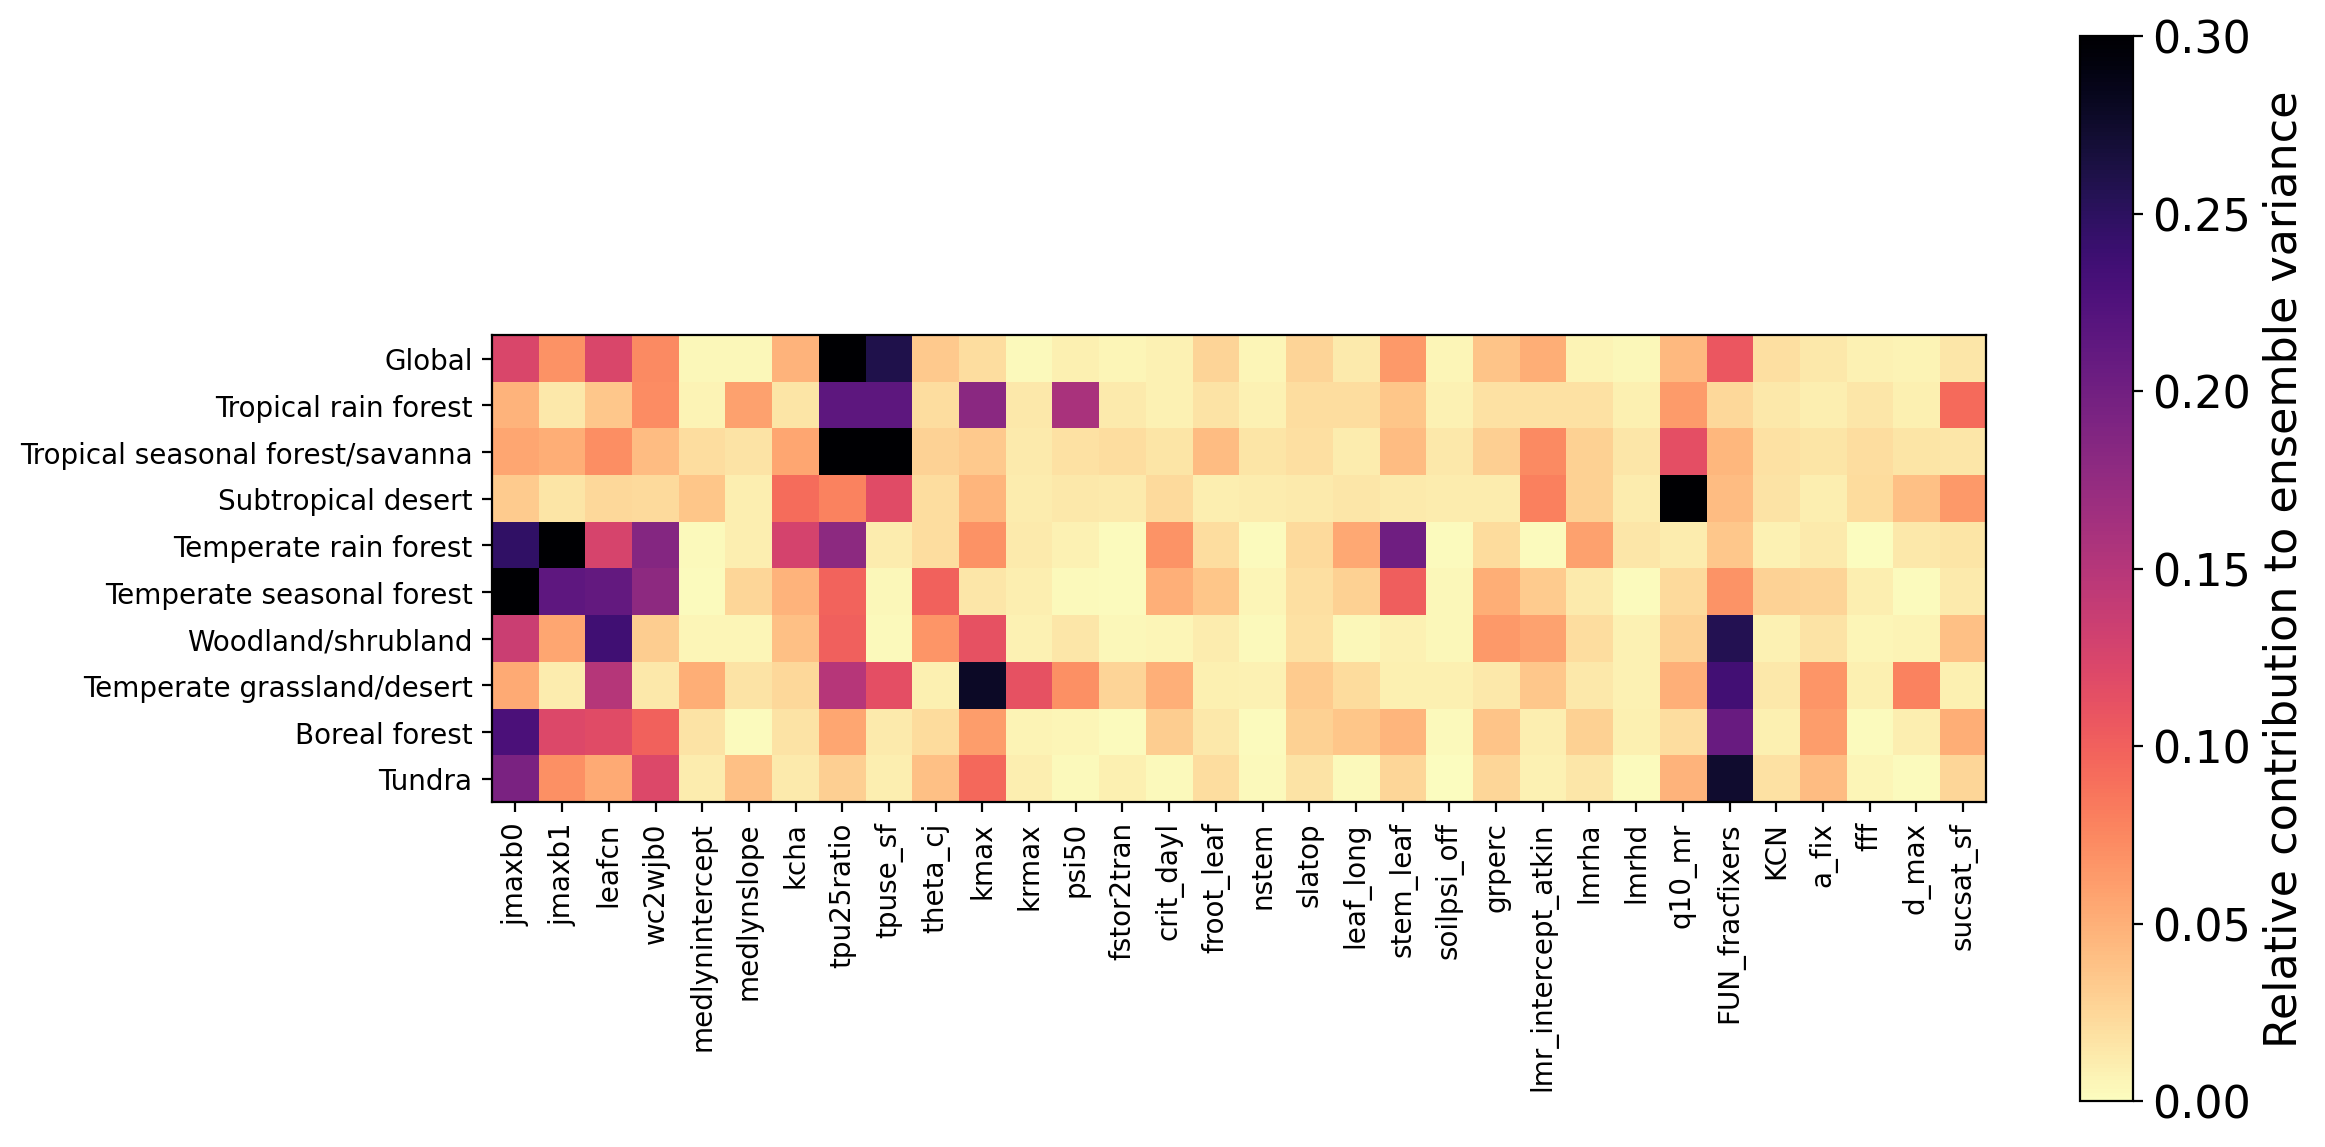

In [19]:
# Heat map
plt.figure(num=None, figsize=(12, 6), dpi=200, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
im = ax.imshow(FAST_sens.transpose(),cmap='magma_r',vmin=0,vmax=0.3)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(params)), labels=params)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_yticks(np.arange(len(var_names)), labels=var_names)

cbar = plt.colorbar(im)
cbar.set_label("Relative contribution to ensemble variance",fontsize=16)
cbar.ax.tick_params(labelsize=16)
#plt.title('Land Sink',fontsize=20)
plt.tight_layout()
#plt.savefig('./working_dir/figs/BGC_cesm23/FAST_sensitivity_LandSink_heatmap_ARDkernel.png',dpi=200)

### FAST for each component of Land Sink

In [18]:
# data
t=slice(str(2001),str(2014))
ds_in = ds.sel(year=t,biome='Global').mean(dim='year')

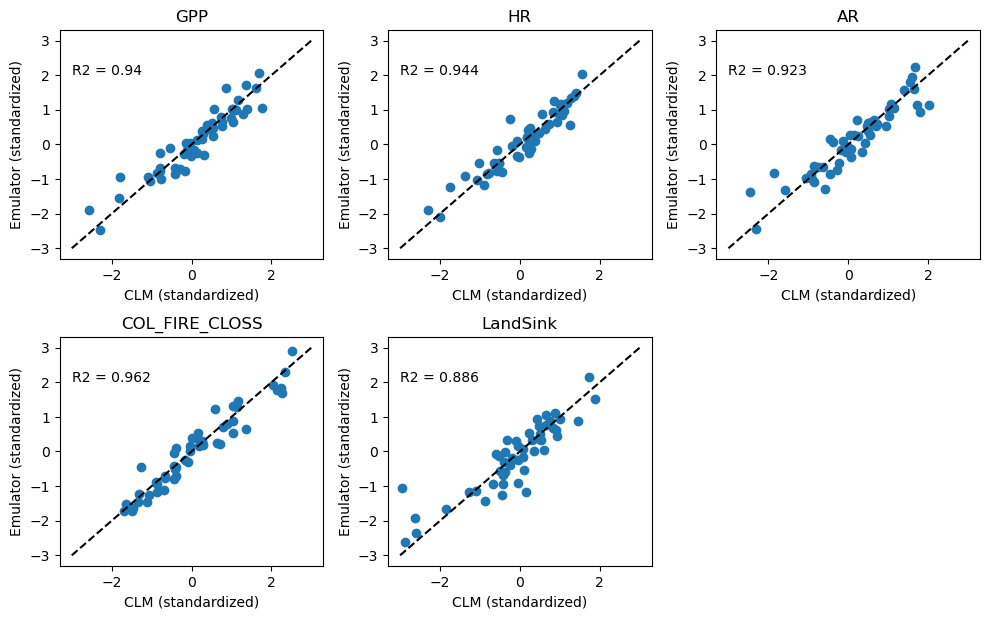

In [22]:
# train emulators and save in a dictionary 
plt.figure(figsize=[10,12])
plt.rcParams.update({'font.size': 10})

LS_emulator_dict = {}
keys = ['GPP','HR','AR','COL_FIRE_CLOSS','LandSink']

for i,v in enumerate(keys):

    y_data = ds_in[v]*cf
    if v =='LandSink':
        y_data = ds_in[v]
    
    ax = plt.subplot(4,3,i+1)

    emulator = train_GPemulator(y_data[1:],ppe_params,50,ax,kernel=kernel)
    
    LS_emulator_dict[keys[i]] = emulator
    
    ax.set_title(keys[i])

plt.tight_layout()
plt.savefig('./working_dir/figs/BGC_cesm23/Global_LandSink_emulator_validation.png',dpi = 100)

In [23]:
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}
sample = fast_sampler.sample(problem, 1000, M=4, seed=None)

In [24]:
for k, v in enumerate(LS_emulator_dict.keys()):
    Y, _ = LS_emulator_dict[v].predict(sample)
    FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
    if k ==0:
        FAST_sens = pd.DataFrame.from_dict(FAST['ST'])
        FAST_sens.columns=[v]
    else:
        FAST_sens[v] = FAST['ST']
        
FAST_sens.index = pd.DataFrame.from_dict(FAST).names

In [25]:
# re order parameters - group by rocess
params = ['jmaxb0', 'jmaxb1', 'leafcn', 'wc2wjb0', 'medlynintercept', 'medlynslope', 'kcha', 'tpu25ratio', 'tpuse_sf', 'theta_cj',
          'kmax', 'krmax', 'psi50', 'fstor2tran','crit_dayl', 'froot_leaf', 'nstem', 'slatop','leaf_long', 'stem_leaf', 'soilpsi_off',
          'grperc', 'lmr_intercept_atkin', 'lmrha', 'lmrhd', 'q10_mr', 'FUN_fracfixers', 'KCN', 'a_fix', 'fff', 'd_max', 'sucsat_sf']

FAST_sens = FAST_sens.reindex(params)
var_names = FAST_sens.columns

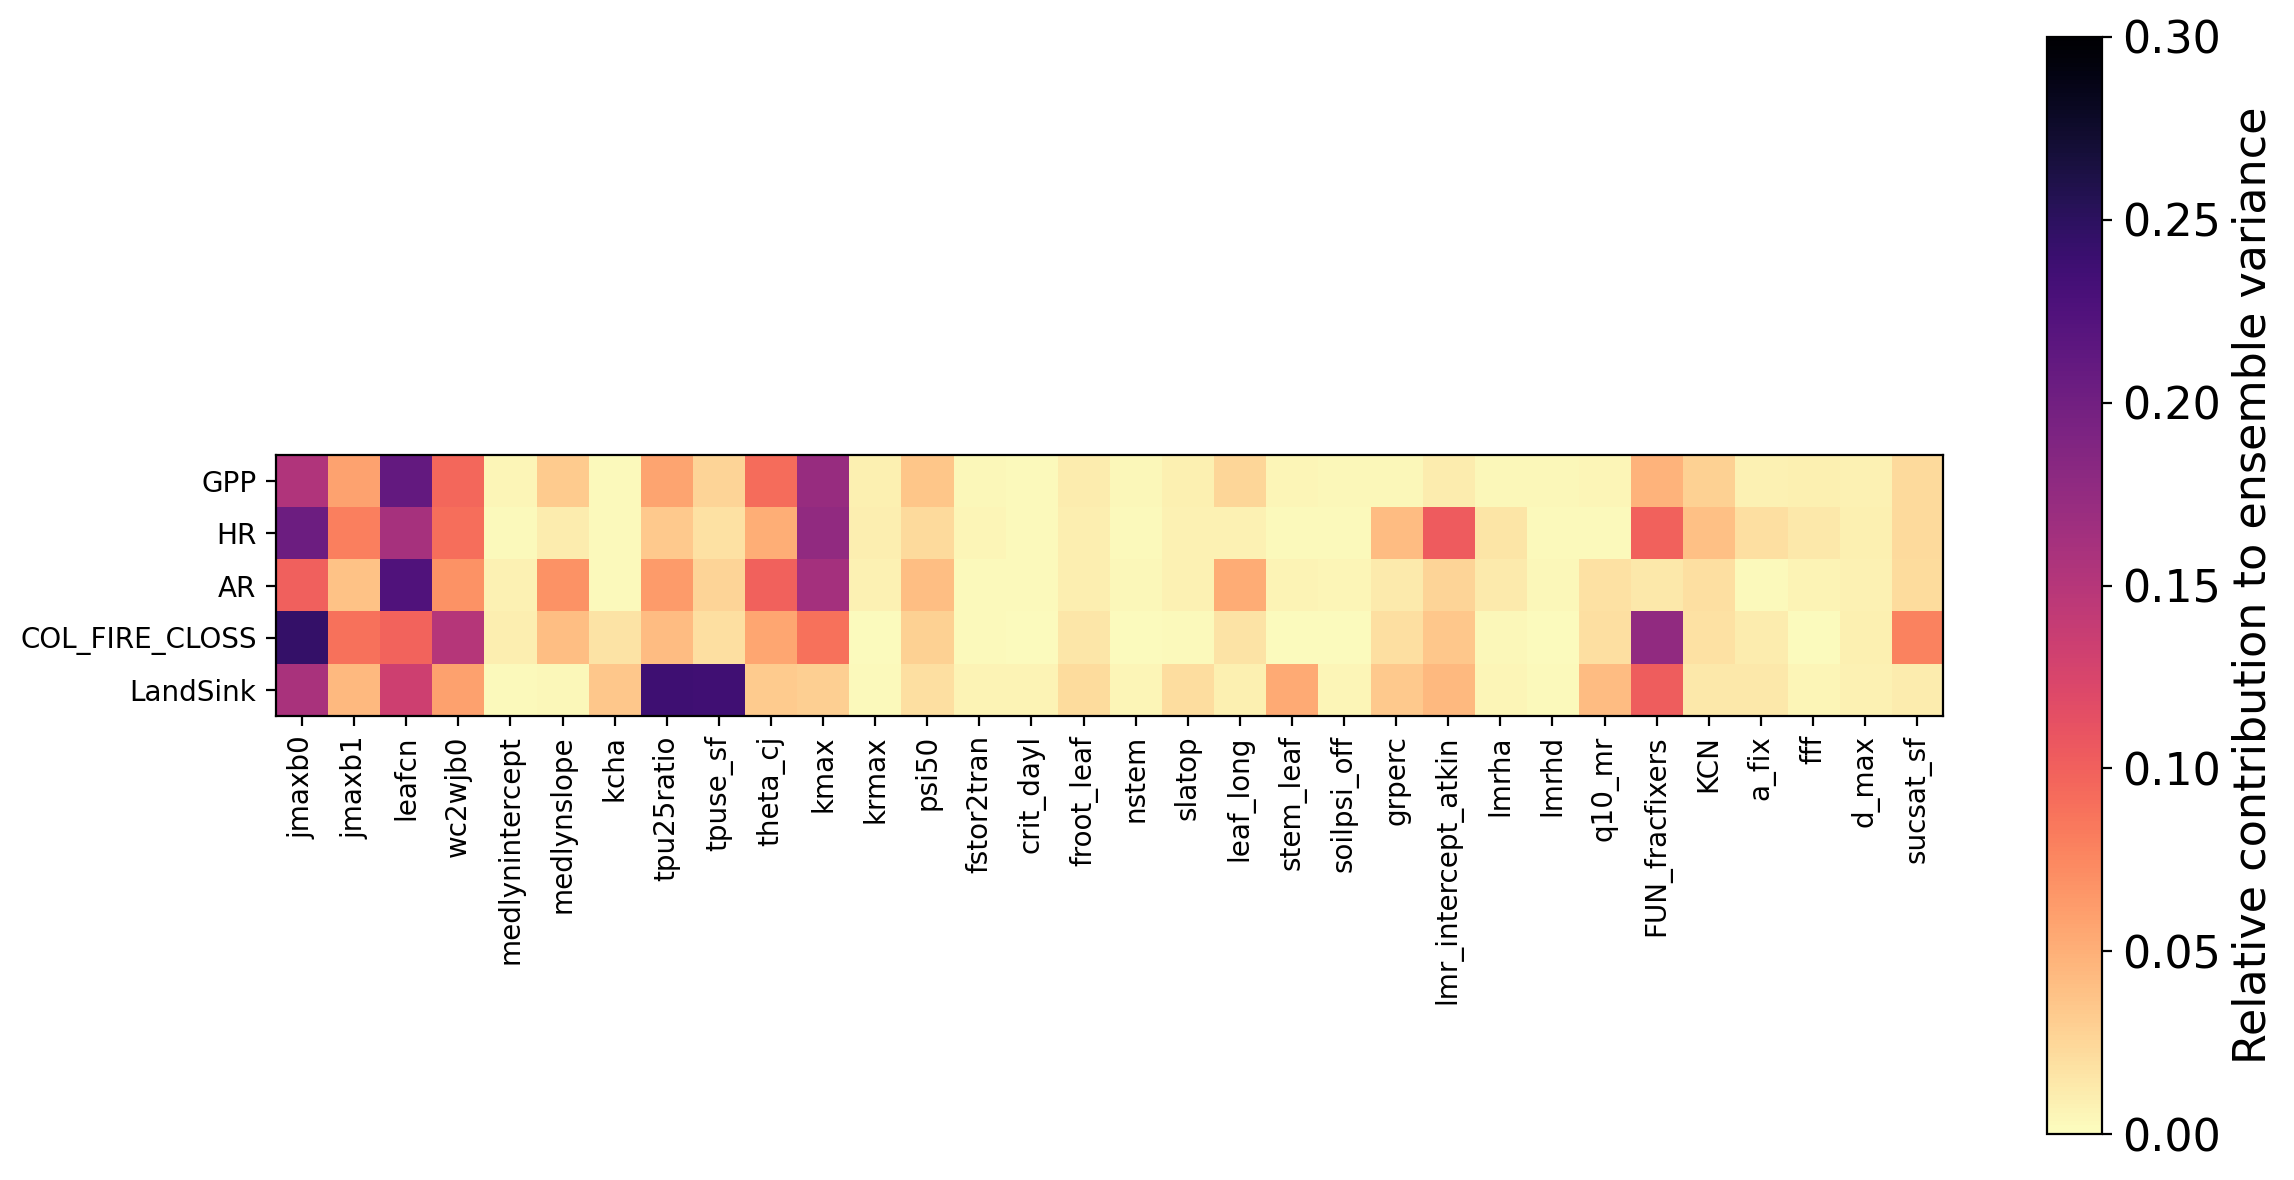

In [26]:
# Heat map
plt.figure(num=None, figsize=(12, 6), dpi=200, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
im = ax.imshow(FAST_sens.transpose(),cmap='magma_r',vmin=0,vmax=0.3)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(params)), labels=params)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_yticks(np.arange(len(var_names)), labels=var_names)

cbar = plt.colorbar(im)
cbar.set_label("Relative contribution to ensemble variance",fontsize=16)
cbar.ax.tick_params(labelsize=16)
#plt.title('Land Sink',fontsize=20)
plt.tight_layout()
plt.savefig('./working_dir/figs/BGC_cesm23/FAST_sensitivity_LandSink_heatmap_global.png',dpi=200)